# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, breaks_cusumolsresid
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import yeojohnson, yeojohnson_normmax, jarque_bera
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

# Data Loading & Visualisation

In [2]:
# Load the data
qqq = pd.read_excel('../data/qqq_data.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Check the data
display(qqq.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,QQQ,34.320947,34.492167,31.213309,32.018024,2234773200,-0.063126,-0.062605,0.010865,-0.000522,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-02-01,QQQ,32.095091,32.942606,31.418755,31.863935,1765610600,-0.004813,-0.005666,0.010056,0.000853,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-03-01,QQQ,31.992344,32.779963,30.768126,31.307474,2133973700,-0.017464,-0.018855,0.008751,0.001391,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-04-01,QQQ,31.521498,31.735519,29.406934,29.946276,2345433600,-0.043478,-0.041645,0.012613,-0.001833,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-05-01,QQQ,30.049009,32.762837,29.869230,32.600197,1881340000,0.088623,0.085755,0.006330,0.002868,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [3]:
# Get information about the data
print("QQQ Data Info:")
display(qqq.describe())
print("\nMacro Data Info:")
display(macro.describe())

QQQ Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Absolute_Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,2.400000e+02,240.00000,240.0,240.00,240.0,240,240.000000,240.0
mean,141.854185,148.410727,135.854721,143.609570,1.380399e+09,0.012765,0.012160,0.012097,0.000605,0.001171,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
min,23.522952,26.702119,21.696006,23.878576,3.074376e+08,-0.155763,-0.162953,0.002915,-0.007349,0.000002,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
25%,41.132771,43.758852,39.327759,41.804646,6.974952e+08,-0.018018,-0.018936,0.007918,-0.000234,0.000434,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
50%,94.027525,97.665560,90.360646,95.052735,1.008536e+09,0.017680,0.017121,0.010193,0.000628,0.000892,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
75%,192.992068,208.999052,183.989309,198.462799,1.776189e+09,0.048497,0.047817,0.014446,0.001344,0.001540,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
max,509.427621,537.480547,507.712944,514.842224,7.240780e+09,0.149738,0.151918,0.057591,0.008237,0.008237,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
std,126.109204,132.364382,120.760418,127.951458,9.793356e+08,0.052866,0.052700,0.006933,0.001482,0.001090,0.000000e+00,1.139244e-13,0.00000,0.0,0.00,0.0,NaN,0.000000,0.0



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


In [4]:
# y=0 dashed line
def add_zero_line(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

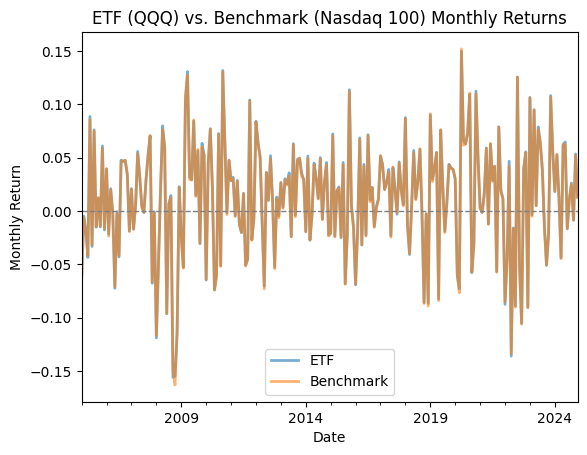

In [5]:
# ETF Returns vs Benchmark Returns
plt.figure()
ax = qqq['ETF_Return'].plot(alpha=0.6, linewidth=2, label='ETF')
qqq['Benchmark_Return'].plot(alpha=0.6, linewidth=2, label='Benchmark', ax=ax)
add_zero_line(ax)
plt.title('ETF (QQQ) vs. Benchmark (Nasdaq 100) Monthly Returns')
plt.xlabel('Date'); plt.ylabel('Monthly Return')
plt.legend()
plt.show()

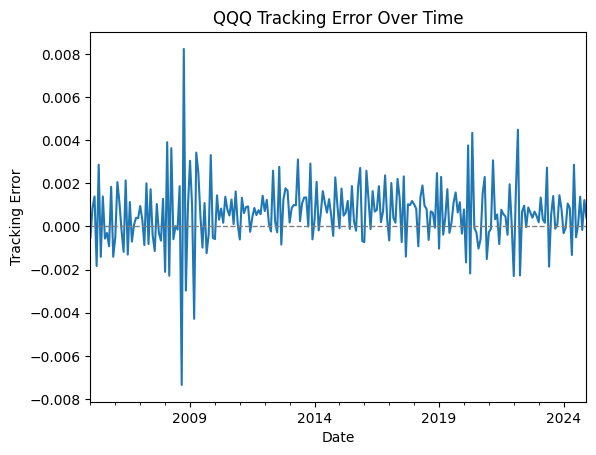

In [6]:
# Tracking Error Plot
plt.figure()
ax = qqq['Tracking_Error'].plot()
add_zero_line(ax)
plt.title('QQQ Tracking Error Over Time')
plt.xlabel('Date'); plt.ylabel('Tracking Error')
plt.show()

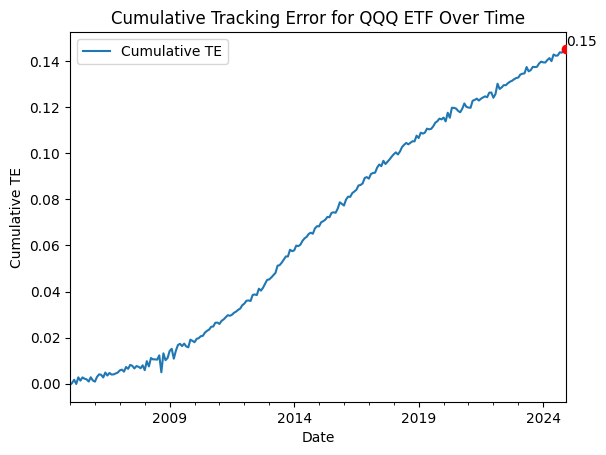

In [7]:
# Cumulative Tracking Error with final‐value marker
cum_te = qqq['Tracking_Error'].cumsum()
plt.figure()
ax = cum_te.plot(label='Cumulative TE')
# Mark & annotate final point
last_date = cum_te.index[-1]
last_val  = cum_te.iloc[-1]
ax.scatter([last_date], [last_val], color='red', zorder=5)
ax.text(last_date, last_val,
        f"{last_val:.2f}",
        va='bottom', ha='left')

plt.title('Cumulative Tracking Error for QQQ ETF Over Time')
plt.xlabel('Date'); plt.ylabel('Cumulative TE')
plt.legend()
plt.show()

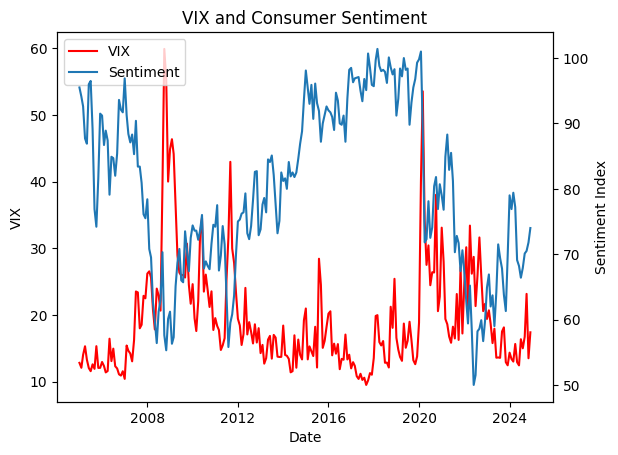

In [8]:
# VIX & Sentiment plots
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

ax2 = ax1.twinx()
ax2.plot(macro['michigan_consumer_sentiment_index'], label='Sentiment')
ax2.set_ylabel('Sentiment Index')

# combine legends
lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labs1+labs2, loc='upper left')
plt.title('VIX and Consumer Sentiment')
plt.show()

# SARIMA-GARCH Model Fitting

1. **Model**  
   We fit a **Seasonal ARIMA** model for the conditional mean and a **GARCH(1,1)** model for the conditional variance of the tracking error series.

2. **Data Preparation**  
   - **Winsorize** extremes in the training data to clamp outliers.  
   - Apply a **Yeo–Johnson transform** to stabilize variance (automatically estimating the best λ parameter).

3. **Rolling-Window Cross-Validation**  
   - Slide a fixed-length window (60 months) forward by a set step (30 months).  
   - At each position, train SARIMA on the window, forecast the next n months, and record **MAE**, **MSE**, and **R²**.  
   - Report the **mean and standard deviation** of these metrics across all folds to assess out-of-sample performance stability.

4. **Final Model Fit & Forecast**  
   - Refit the chosen SARIMA on all but the last n points.  
   - Invert the transform to get point forecasts for those final n months.

5. **GARCH Uncertainty Quantification**  
   - Fit GARCH(1,1) to the SARIMA residuals to capture time-varying volatility.  
   - Forecast future variances and build 95% confidence intervals around each point forecast.

6. **Diagnostics & Metrics**  
   - Run **Ljung–Box**, **Jarque–Bera**, **ARCH-LM**, and **CUSUM** tests on both SARIMA and GARCH residuals.  
   - Compute separate **in-sample** and **out-of-sample** MAE, MSE, and R² for the final fit.

7. **Visualization**  
   - Optionally plot the last 10 observed points (solid line), the n-month forecast (dashed line), and the GARCH-based 95% error bars to show both predictions and uncertainty.  


In [9]:
def inv_yeojohnson(x, lmbda):
    """
    Invert a Yeo–Johnson transform.

    Parameters
    ----------
    x : array-like
        Transformed data.
    lmbda : float
        Yeo–Johnson lambda used in the forward transform.

    Returns
    -------
    y : numpy.ndarray
        Original data (inverse-transformed).
    """
    x = np.asarray(x, float)
    y = np.zeros_like(x)
    pos, neg = x >= 0, x < 0

    # Positive branch
    if lmbda != 0:
        y[pos] = (x[pos] * lmbda + 1) ** (1 / lmbda) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1
    # Negative branch
    if lmbda != 2:
        y[neg] = 1 - ((-x[neg] * (2 - lmbda) + 1) ** (1 / (2 - lmbda)))
    else:
        y[neg] = 1 - np.exp(-x[neg])

    return y

In [10]:
def fit_sarima_garch_cv(
    series: pd.Series,
    n: int = 3,
    cv_window: int = 60,
    cv_step: int = 10,
    n_jobs: int = -1,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    ljungbox_lags: int = 10,
    alpha: float = 0.05,
    forecast_plot: bool = False
) -> dict:
    """
    Fit a seasonal ARIMA+GARCH model with rolling-window cross-validation.

    This function performs:
    1. Rolling-window cross-validation (CV) on SARIMA-only forecasts:
       - CV window length = cv_window
       - Step between windows = cv_step
       - Forecast horizon = n
       - Parallelized over n_jobs
       Aggregates MAE, MSE, R² as mean ± std.
    2. Final model fit on full training data (excluding last n points),
       then fits GARCH(1,1) on the residuals for variance forecasting.
    3. Diagnostic tests (Ljung–Box, Jarque–Bera, ARCH LM, CUSUM)
       for both SARIMA residuals and GARCH standardized residuals.
    4. Computes separate in-sample and out-of-sample metrics (R², MAE, MSE).
    5. Optionally, plots the last 10 actuals + n-step forecast with
       95% GARCH-based confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Time series of tracking error (date index).
    n : int
        Forecast horizon (number of periods ahead).
    cv_window : int
        Number of observations in each CV training window.
    cv_step : int
        Step size (in observations) between CV windows.
    n_jobs : int
        Number of parallel jobs for CV (joblib).
    winsor_limits : tuple
        Lower/upper tail proportion for winsorization.
    seasonal_period : int
        Seasonal period for SARIMA (e.g., 12 for monthly data).
    ljungbox_lags : int
        Number of lags for Ljung–Box test.
    alpha : float
        Significance level for diagnostic tests.
    forecast_plot : bool
        If True, plot last 10 + n forecast with GARCH CIs.

    Returns
    -------
    dict
        {
          'order': (p,d,q,P,D,Q,m),
          'aic': aic_value,
          'bic': bic_value,
          'diagnostics': {
              'sarima': {...},
              'garch': {...}
          },
          'cv_metrics': {
              'MAE_mean', 'MAE_std',
              'MSE_mean', 'MSE_std',
              'R2_mean',  'R2_std',
              'folds'
          },
          'metrics': {
              'in_sample': {'R2','MAE','MSE'},
              'out_sample': {'R2','MAE','MSE'}
          }
        }
    """
    # --- Data preparation ---
    y = series.dropna()
    N = len(y)
    if N < cv_window + n:
        raise ValueError("Not enough data: need cv_window + n observations.")

    # --- 1) Rolling-window CV ---
    fold_ends = range(cv_window, N - n + 1, cv_step)
    def _cv_fold(end):
        train = y.iloc[end-cv_window:end]
        test  = y.iloc[end:end+n]
        # Winsorize extremes
        w = winsorize(train.values, limits=winsor_limits)
        tw = pd.Series(w, index=train.index)
        # Yeo–Johnson transform
        shift = -tw.min() + 1e-6
        tj = tw + shift
        lam = yeojohnson_normmax(tj)
        tt = yeojohnson(tj, lmbda=lam)
        # Fit SARIMA on transformed data
        m = auto_arima(
            tt,
            seasonal=True, m=seasonal_period,
            information_criterion='bic',
            max_p=5, max_q=5, max_d=3,
            max_P=5, max_Q=5, max_D=3,
            maxiter=20, stepwise=True,
            suppress_warnings=True, error_action='ignore'
        )
        # Forecast & invert
        fc_t = m.predict(n_periods=n)
        fc = inv_yeojohnson(fc_t, lam) - shift
        return (
            mean_absolute_error(test, fc),
            mean_squared_error(test, fc),
            r2_score(test, fc)
        )
    results = Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends)
    mae_cv, mse_cv, r2_cv = zip(*results)
    cv_metrics = {
        'MAE_mean': np.mean(mae_cv), 'MAE_std': np.std(mae_cv),
        'MSE_mean': np.mean(mse_cv), 'MSE_std': np.std(mse_cv),
        'R2_mean':  np.mean(r2_cv),  'R2_std':  np.std(r2_cv),
        'folds':    len(results)
    }

    # Print CV summary
    print("\n=== Cross-Validation Results ===")
    print(f"Number of folds: {cv_metrics['folds']}")
    print(f"MAE (mean ± std): {cv_metrics['MAE_mean']:.6f} ± {cv_metrics['MAE_std']:.6f}")
    print(f"MSE (mean ± std): {cv_metrics['MSE_mean']:.6f} ± {cv_metrics['MSE_std']:.6f}")
    print(f"R²  (mean ± std): {cv_metrics['R2_mean']:.6f} ± {cv_metrics['R2_std']:.6f}")

    # --- 2) Final model fit ---
    train, test = y.iloc[:-n], y.iloc[-n:]
    # Winsorize & transform on full train
    w = winsorize(train.values, limits=winsor_limits)
    tw = pd.Series(w, index=train.index)
    shift = -tw.min() + 1e-6
    tj = tw + shift
    lam = yeojohnson_normmax(tj)
    tt = yeojohnson(tj, lmbda=lam)
    # Fit SARIMA
    model = auto_arima(
        tt,
        seasonal=True, m=seasonal_period,
        information_criterion='bic',
        max_p=5, max_q=5, max_d=3,
        max_P=5, max_Q=5, max_D=3,
        maxiter=20, stepwise=True,
        suppress_warnings=True, error_action='ignore'
    )
    p, d, q = model.order
    P, D, Q, m = model.seasonal_order
    res = model.arima_res_
    aic, bic = float(res.aic), float(res.bic)
    resid = pd.Series(res.resid).dropna()
    # In-sample fit
    fit_t = model.predict_in_sample()
    fitted = inv_yeojohnson(fit_t, lam) - shift
    # Out-of-sample forecast
    fc_t = model.predict(n_periods=n)
    fcst = inv_yeojohnson(fc_t, lam) - shift

    # --- GARCH variance forecasting ---
    sd = resid.std()
    r_std = resid / sd
    gmod = arch_model(r_std, vol='Garch', p=1, q=1, dist='t', rescale=False)
    gres = gmod.fit(disp='off')
    std_resid = pd.Series(gres.std_resid).dropna()
    var_h = gres.forecast(horizon=n, reindex=False).variance.iloc[-1]
    sigma_fc = np.sqrt(var_h * sd**2)

    # --- 3) Diagnostics ---
    def run_diag(r):
        lb = acorr_ljungbox(r, lags=[ljungbox_lags], return_df=True).iloc[0]
        jb_s, jb_p = jarque_bera(r)[:2]
        arch_s, arch_p, *_ = het_arch(r, nlags=ljungbox_lags)
        cb = breaks_cusumolsresid(r, ddof=0)
        return {
            'Ljung-Box':   (lb['lb_stat'], lb['lb_pvalue']),
            'Jarque-Bera': (jb_s, jb_p),
            'ARCH LM':     (arch_s, arch_p),
            'CUSUM':       (cb[0], np.min(np.atleast_1d(cb[-1])))
        }
    diag_arima = run_diag(resid)
    diag_garch = run_diag(std_resid)

    # --- 4) In-/Out-of-sample metrics ---
    metrics = {
        'in_sample': {
            'R2':  r2_score(train, fitted),
            'MAE': mean_absolute_error(train, fitted),
            'MSE': mean_squared_error(train, fitted)
        },
        'out_sample': {
            'R2':  r2_score(test, fcst),
            'MAE': mean_absolute_error(test, fcst),
            'MSE': mean_squared_error(test, fcst)
        }
    }

    # Print final diagnostics & metrics
    print("\n=== Final Model Diagnostics ===")
    print(f"SARIMA order (p,d,q): ({p},{d},{q})×({P},{D},{Q})[{m}]    AIC={aic:.2f}    BIC={bic:.2f}")
    def fmt(di):
        df = pd.DataFrame(di, index=['stat','pvalue']).T
        df['Result'] = np.where(df['pvalue'] > alpha, 'Pass', 'Fail')
        return df[['stat','pvalue','Result']]
    print("\nSARIMA residual diagnostics:\n", fmt(diag_arima))
    print("\nGARCH std-residual diagnostics:\n", fmt(diag_garch))

    print("\n=== In-Sample vs Out-of-Sample Metrics ===")
    dfm = pd.DataFrame(metrics).T
    print(dfm.to_string(float_format='%.6f'))

    # --- 5) Optional forecast plot ---
    if forecast_plot:
        preview_n = 10
        split = len(y) - n
        idx_prev = y.index[split-preview_n:split]
        vals_prev = y.iloc[split-preview_n:split].values
        idx_test = test.index

        actual_idx = list(idx_prev) + list(idx_test)
        actual_vals = np.concatenate([vals_prev, test.values])
        fc_idx = [idx_prev[-1]] + list(idx_test)
        fc_vals = [vals_prev[-1]] + list(fcst)

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(actual_idx, actual_vals, '-o', color='C0', label='Actual', zorder=3)
        ax.plot(fc_idx, fc_vals, '--o', color='C1', label='Forecast', zorder=2)
        ax.errorbar(idx_test, fcst, yerr=1.96*sigma_fc,
                    fmt='none', ecolor='grey', alpha=0.5, capsize=5,
                    label='GARCH 95% CI', zorder=1)
        ymin = min(actual_vals.min(), (fcst - 1.96*sigma_fc).min())
        ymax = max(actual_vals.max(), (fcst + 1.96*sigma_fc).max())
        ax.set_ylim(ymin * 1.1, ymax * 1.1)
        ax.set_title(f'Last {preview_n} Actuals + {n}-Step Forecast with GARCH CI')
        ax.set_xlabel('Date')
        ax.set_ylabel(series.name or 'Value')
        ax.legend()
        plt.show()

    return {
        'order':       (p, d, q, P, D, Q, m),
        'aic':         aic,
        'bic':         bic,
        'diagnostics': {'sarima': diag_arima, 'garch': diag_garch},
        'cv_metrics':  cv_metrics,
        'metrics':     metrics
    }


=== Cross-Validation Results ===
Number of folds: 6
MAE (mean ± std): 0.001028 ± 0.000657
MSE (mean ± std): 0.000002 ± 0.000002
R²  (mean ± std): 0.152408 ± 0.340510

=== Final Model Diagnostics ===
SARIMA order (p,d,q): (2,1,1)×(1,0,1)[12]    AIC=-2569.43    BIC=-2545.18

SARIMA residual diagnostics:
                   stat    pvalue Result
Ljung-Box    31.330956  0.000517   Fail
Jarque-Bera   3.205909  0.201301   Pass
ARCH LM      29.183059  0.001164   Fail
CUSUM         1.026074  1.000000   Pass

GARCH std-residual diagnostics:
                   stat    pvalue Result
Ljung-Box    21.435508  0.018253   Fail
Jarque-Bera   0.660828  0.718626   Pass
ARCH LM      10.711723  0.380414   Pass
CUSUM         0.795527  1.000000   Pass

=== In-Sample vs Out-of-Sample Metrics ===
                 R2      MAE      MSE
in_sample  0.264955 0.000900 0.000002
out_sample 0.459988 0.000352 0.000000


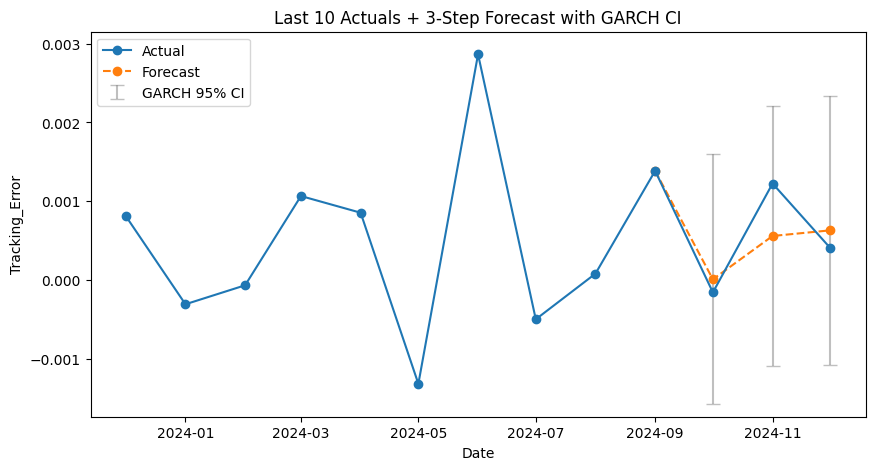

In [11]:
results = fit_sarima_garch_cv(
    qqq['Tracking_Error'],
    n=3,
    cv_window=60,    # 5 years of monthly data
    cv_step=30,      # Jump by 30 months each fold
    n_jobs=-1,       # use all CPU cores
    forecast_plot=True
)

# MS-SARIMA Model Fitting

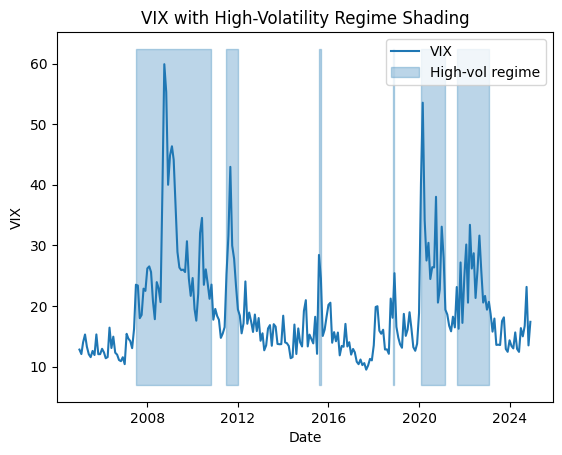

In [ ]:
vix = macro['vix']

# 1) Fit 2-state Markov model on VIX
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# 2) Extract high-volatility regime probability
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]

# 3) Plot VIX and highlight high-vol regions
fig, ax = plt.subplots()
x = vix.index

# Plot VIX line
line, = ax.plot(x, vix.values, label='VIX')

# Determine vertical extent
ymin, ymax = ax.get_ylim()

# Shade high-volatility regimes (probability > 0.5)
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.5),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Labels, title, legend
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')
ax.legend(loc='upper right')

plt.show()


In [13]:
def fit_ms_sarima_vix_cv(
    series: pd.Series,
    vix: pd.Series,
    n: int = 3,
    cv_window: int = 60,
    cv_step: int = 10,
    n_jobs: int = -1,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    ljungbox_lags: int = 10,
    alpha: float = 0.05,
    forecast_plot: bool = True
) -> dict:
    """
    Two-state VIX-driven MS-SARIMA with rolling-window CV, diagnostics, and plotting.
    """
    # Data prep
    y = series.dropna()
    N = len(y)
    if N < cv_window + n:
        raise ValueError("Not enough data: need cv_window + n observations.")

    # 1) Rolling-window CV
    mae, mse, r2 = [], [], []
    for end in range(cv_window, N - n + 1, cv_step):
        y_tr, y_te = y.iloc[:end], y.iloc[end:end+n]
        v_tr = vix.iloc[:end]

        # (a) VIX regime estimation
        mr = MarkovRegression(v_tr, k_regimes=2, trend='c', switching_variance=True)
        res_mr = mr.fit(disp=False)
        p00, p10 = res_mr.params['p[0->0]'], res_mr.params['p[1->0]']
        P = np.array([[p00, 1-p00], [p10, 1-p10]])
        prob_high = res_mr.smoothed_marginal_probabilities.iloc[:,1]
        regimes = prob_high > 0.35

        # (b) Function to fit auto_arima on a regime subset
        def regime_fit(ts):
            w = winsorize(ts.values, limits=winsor_limits)
            tw = pd.Series(w, index=ts.index)
            shift = -tw.min() + 1e-6
            t0 = tw + shift
            lam = yeojohnson_normmax(t0)
            tt = yeojohnson(t0, lmbda=lam)
            m = auto_arima(
                tt,
                seasonal=True, m=seasonal_period,
                information_criterion='bic',
                stepwise=True, suppress_warnings=True, error_action='ignore',
                max_p=5, max_q=5, max_d=3,
                max_P=5, max_Q=5, max_D=3,
                n_jobs=n_jobs
            )
            fc_t = m.predict(n_periods=n)
            fc = inv_yeojohnson(fc_t, lam) - shift
            return m, fc, lam, shift

        # (c) Fit for low/high volatility regimes
        m_low,  fc_low,  lam_low,  shift_low  = regime_fit(y_tr.loc[~regimes])
        m_high, fc_high, lam_high, shift_high = regime_fit(y_tr.loc[regimes])

        # (d) Mix forecasts
        p_vec = np.array([1-prob_high.iloc[-1], prob_high.iloc[-1]])
        fc_mix = []
        for h in range(n):
            p_vec = p_vec.dot(P)
            fc_mix.append(p_vec[0]*fc_low[h] + p_vec[1]*fc_high[h])
        fc_mix = np.array(fc_mix)

        # (e) CV errors
        mae.append(mean_absolute_error(y_te, fc_mix))
        mse.append(mean_squared_error(y_te, fc_mix))
        r2.append(r2_score(y_te, fc_mix))

    folds = len(mae)
    MAE_mean, MAE_std = np.mean(mae), np.std(mae)
    MSE_mean, MSE_std = np.mean(mse), np.std(mse)
    R2_mean,  R2_std  = np.mean(r2),  np.std(r2)

    # Print CV Results
    print("=== Cross-Validation Results ===")
    print(f"Number of folds: {folds}")
    print(f"MAE (mean ± std): {MAE_mean:.6f} ± {MAE_std:.6f}")
    print(f"MSE (mean ± std): {MSE_mean:.6f} ± {MSE_std:.6f}")
    print(f"R²  (mean ± std): {R2_mean:.6f} ± {R2_std:.6f}")

    # 2) Final Fit & Diagnostics
    end_full = N - n
    y_tr, y_te = y.iloc[:end_full], y.iloc[end_full:]
    v_tr = vix.iloc[:end_full]

    res_f = MarkovRegression(v_tr, k_regimes=2, trend='c', switching_variance=True)\
            .fit(disp=False)
    p00_f, p10_f = res_f.params['p[0->0]'], res_f.params['p[1->0]']
    P_full = np.array([[p00_f,1-p00_f],[p10_f,1-p10_f]])
    prob_high_f = res_f.smoothed_marginal_probabilities.iloc[:,1]
    regimes_f   = prob_high_f > 0.35

    m_low_f,  fc_low_f,  lam_low_f,  shift_low_f  = regime_fit(y_tr.loc[~regimes_f])
    m_high_f, fc_high_f, lam_high_f, shift_high_f = regime_fit(y_tr.loc[regimes_f])

    # In-sample fits
    fit_low_t  = m_low_f.predict_in_sample()
    fit_low    = inv_yeojohnson(fit_low_t, lam_low_f) - shift_low_f
    fit_high_t = m_high_f.predict_in_sample()
    fit_high   = inv_yeojohnson(fit_high_t, lam_high_f) - shift_high_f

    fitted_full = pd.Series(index=y_tr.index, dtype=float)
    fitted_full.loc[~regimes_f] = fit_low
    fitted_full.loc[regimes_f]  = fit_high

    # Out-of-sample mixed forecast & regime-probs
    p_vec = np.array([1-prob_high_f.iloc[-1], prob_high_f.iloc[-1]])
    fc_mix_f, reg_pred = [], []
    for h in range(n):
        p_vec = p_vec.dot(P_full)
        fc_mix_f.append(p_vec[0]*fc_low_f[h] + p_vec[1]*fc_high_f[h])
        reg_pred.append(p_vec[1])

    # Residual diagnostics (Ljung-Box, JB, ARCH LM)
    def run_diag(r):
        lb = acorr_ljungbox(r, lags=[ljungbox_lags], return_df=True).iloc[0]
        jb_s, jb_p = jarque_bera(r)[:2]
        arch_s, arch_p, _, _ = het_arch(r, nlags=ljungbox_lags)
        return {'Ljung-Box':(lb['lb_stat'],lb['lb_pvalue']),
                'Jarque-Bera':(jb_s,jb_p),
                'ARCH LM':(arch_s,arch_p)}

    # extract the actual residuals from the underlying statsmodels fit
    diag_low  = run_diag(pd.Series(m_low_f.arima_res_.resid).dropna())
    diag_high = run_diag(pd.Series(m_high_f.arima_res_.resid).dropna())

    print("\n=== Final Model Diagnostics ===")
    print(f"Low-vol ARIMA order: {m_low_f.order}×{m_low_f.seasonal_order}    "
          f"AIC={m_low_f.aic():.2f}    BIC={m_low_f.bic():.2f}")
    print(f"High-vol ARIMA order: {m_high_f.order}×{m_high_f.seasonal_order}    "
          f"AIC={m_high_f.aic():.2f}    BIC={m_high_f.bic():.2f}\n")
    print("Transition matrix:")
    print(pd.DataFrame(P_full, index=['from low','from high'],
                       columns=['to low','to high']))
    print("\nLow-vol residual diagnostics:\n", pd.DataFrame(diag_low).T)
    print("\nHigh-vol residual diagnostics:\n", pd.DataFrame(diag_high).T)

    # In-/Out-of-sample metrics
    in_mae, in_mse, in_r2 = mean_absolute_error(y_tr, fitted_full), \
                            mean_squared_error(y_tr, fitted_full), \
                            r2_score(y_tr, fitted_full)
    out_mae, out_mse, out_r2 = mean_absolute_error(y_te, fc_mix_f), \
                               mean_squared_error(y_te, fc_mix_f), \
                               r2_score(y_te, fc_mix_f)

    print("\n=== In-Sample vs Out-of-Sample Metrics ===")
    dfm = pd.DataFrame({
        'R2':  [in_r2,  out_r2],
        'MAE': [in_mae, out_mae],
        'MSE': [in_mse, out_mse]
    }, index=['in_sample','out_sample'])
    print(dfm.to_string(float_format='%.6f'))

    # 3) Plot last 10 actuals + forecasts with regime shading
    if forecast_plot:
        preview_n = 10
        split = len(y) - n
        idx_prev = y.index[split-preview_n:split]
        vals_prev = y.iloc[split-preview_n:split].values
        idx_test = y.index[split:]
        # Combined actual and forecast for plotting
        actual_idx = list(idx_prev) + list(idx_test)
        actual_vals = np.concatenate([vals_prev, y.iloc[split:].values])
        fc_idx = [idx_prev[-1]] + list(idx_test)
        fc_vals = np.concatenate([[vals_prev[-1]], fc_mix_f])

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(actual_idx, actual_vals, '-o', color='C0', label='Actual')
        ax.plot(fc_idx, fc_vals, '--o', color='C1', label='Forecast')

        # Regime shading
        shade_probs = pd.concat([
            prob_high_f.iloc[-preview_n:],
            pd.Series(reg_pred, index=idx_test)
        ])
        ymin, ymax = ax.get_ylim()
        ax.fill_between(
            shade_probs.index, ymin, ymax,
            where=shade_probs > 0.35,
            color='C2', alpha=0.7,
            label='High-vol regime'
        )

        ax.set_title(f'Last {preview_n} Actuals + {n}-Step Forecast with Regime Shading')
        ax.set_xlabel('Date')
        ax.set_ylabel(series.name or 'Value')
        ax.legend(loc='upper right')
        plt.show()

    return {
        'cv_metrics':        {'folds':folds, 'MAE_mean':MAE_mean, 'MAE_std':MAE_std,
                              'MSE_mean':MSE_mean, 'MSE_std':MSE_std,
                              'R2_mean':R2_mean,   'R2_std':R2_std},
        'transition_matrix': P_full,
        'orders':            {'low':m_low_f.order+m_low_f.seasonal_order,
                              'high':m_high_f.order+m_high_f.seasonal_order},
        'diagnostics':       {'low_resid':diag_low, 'high_resid':diag_high},
        'metrics':           {'in_sample':{'R2':in_r2,'MAE':in_mae,'MSE':in_mse},
                              'out_sample':{'R2':out_r2,'MAE':out_mae,'MSE':out_mse}}
    }

=== Cross-Validation Results ===
Number of folds: 6
MAE (mean ± std): 0.000977 ± 0.000610
MSE (mean ± std): 0.000002 ± 0.000002
R²  (mean ± std): 0.299420 ± 0.337321

=== Final Model Diagnostics ===
Low-vol ARIMA order: (1, 0, 0)×(0, 0, 0, 12)    AIC=-1594.65    BIC=-1585.70
High-vol ARIMA order: (0, 0, 1)×(0, 0, 1, 12)    AIC=-913.31    BIC=-903.26

Transition matrix:
             to low   to high
from low   0.958206  0.041794
from high  0.075915  0.924085

Low-vol residual diagnostics:
                      0         1
Ljung-Box    37.064719  0.000055
Jarque-Bera   1.788280  0.408959
ARCH LM       4.966771  0.893387

High-vol residual diagnostics:
                       0             1
Ljung-Box     17.986659  5.518910e-02
Jarque-Bera  116.319478  5.515011e-26
ARCH LM        6.166145  8.011166e-01

=== In-Sample vs Out-of-Sample Metrics ===
                 R2      MAE      MSE
in_sample  0.313514 0.000935 0.000002
out_sample 0.411245 0.000410 0.000000


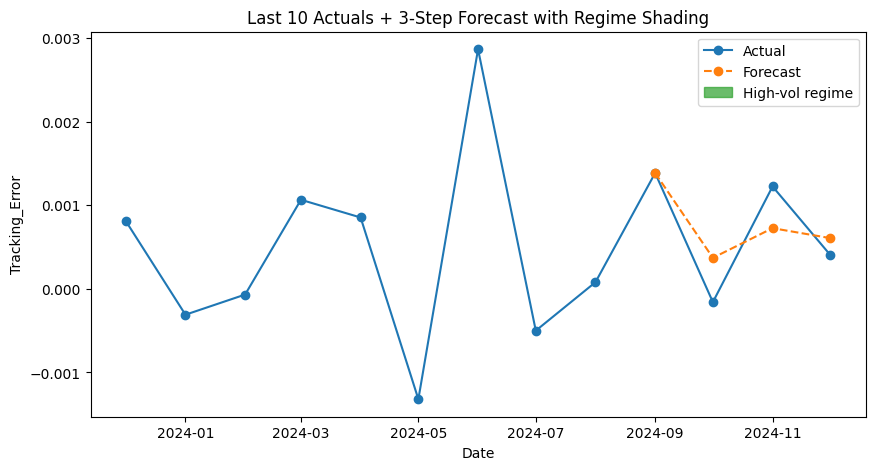

Cross-Validation Results: {'folds': 6, 'MAE_mean': 0.0009767468240417891, 'MAE_std': 0.0006099278183671977, 'MSE_mean': 1.7885955180455909e-06, 'MSE_std': 1.7755070674257998e-06, 'R2_mean': 0.29941973600419997, 'R2_std': 0.33732131016090544}
Transition Matrix:
 [[0.95820621 0.04179379]
 [0.07591458 0.92408542]]
Final In/Out Sample Metrics: {'in_sample': {'R2': 0.3135144305607578, 'MAE': 0.0009348908089577215, 'MSE': 1.518116313041677e-06}, 'out_sample': {'R2': 0.4112451291886958, 'MAE': 0.00040996672221468145, 'MSE': 1.8984453143076799e-07}}


In [14]:
results = fit_ms_sarima_vix_cv(
    series=qqq['Tracking_Error'],
    vix=macro['vix'],
    n=3,
    cv_window=60,
    cv_step=30,
    winsor_limits=(0.01, 0.01),
    seasonal_period=12,
    ljungbox_lags=10,
    alpha=0.05,
    forecast_plot=True
)

# Then you can inspect the outputs:
print("Cross-Validation Results:", results['cv_metrics'])
print("Transition Matrix:\n", results['transition_matrix'])
print("Final In/Out Sample Metrics:", results['metrics'])
